In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.
     |████████████████████████████████| 4.1 MB 5.4 MB/s 


In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tensorflow import keras


In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
print(TRAIN_LENGTH)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

3680


In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

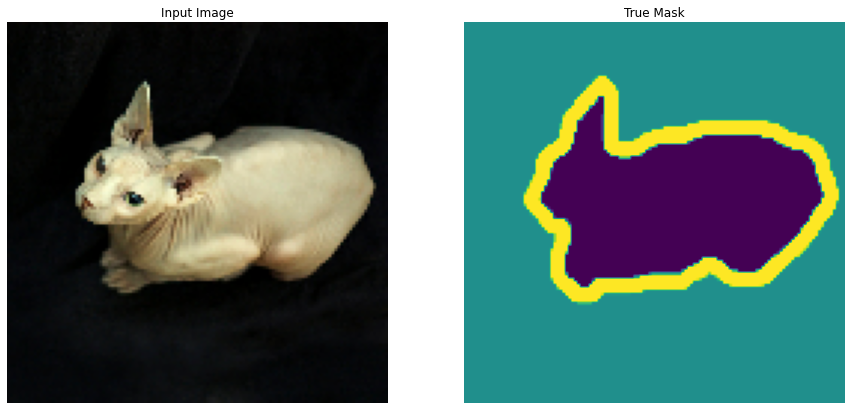

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
!pip install segmentation-models

     |████████████████████████████████| 50 kB 6.1 MB/s 


In [ ]:
from segmentation_models import Unet

unet_model = Unet('resnet34',encoder_weights=None)

Segmentation Models: using `keras` framework.


In [ ]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [ ]:
inputs = keras.Input(shape=(128,128,3))
middle_model = keras.Model(unet_model.inputs,unet_model.layers[-3].output)

x = middle_model(inputs)
x = keras.layers.Conv2D(3, (3,3), padding='same')(x)

model = keras.Model(inputs,x)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model_2 (Functional)        (None, None, None, 16)    24456009  
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 3)       435       
                                                                 
Total params: 24,456,444
Trainable params: 24,439,094
Non-trainable params: 17,350
_________________________________________________________________


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
  
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

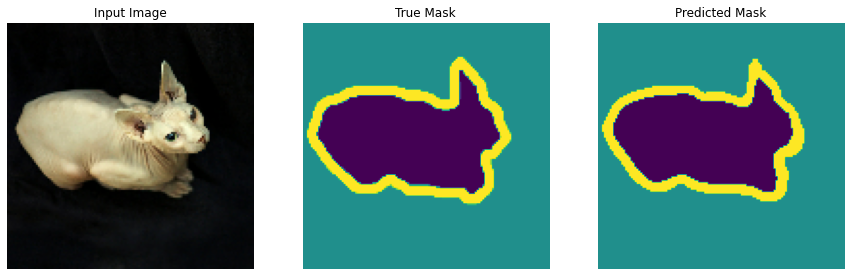


에포크 이후 예측 예시 20

57/57 [==============================] - 34s 597ms/step - loss: 0.2203 - val_loss: 0.3477


In [ ]:
model.compile('Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

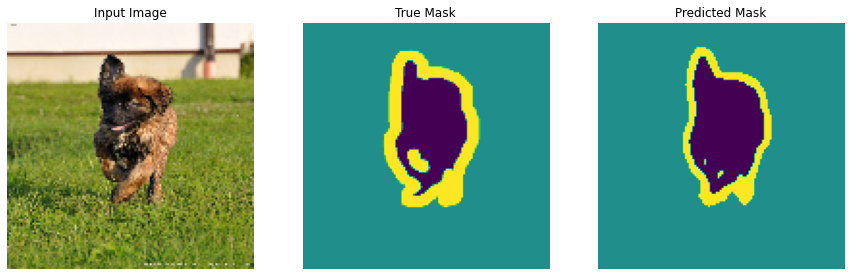

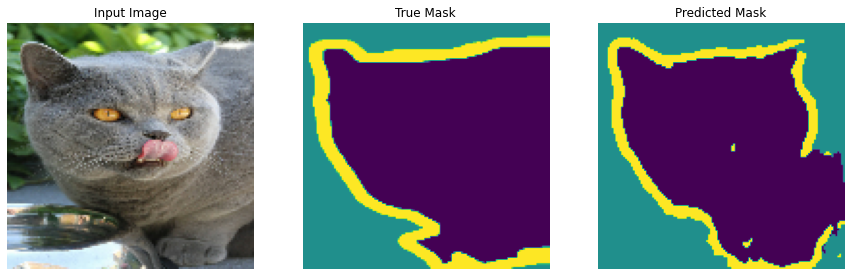

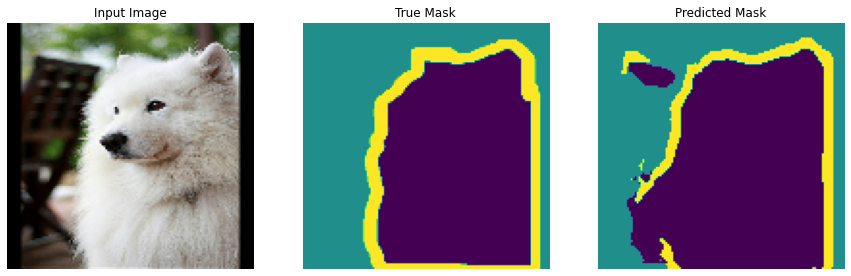

In [ ]:
show_predictions(test_dataset,3)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask  

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (224, 224))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (224, 224))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask  

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]



# myModel 재정의
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = myModel.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(myModel.predict(sample_image[tf.newaxis, ...]))])
    
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [39]:
'''
TODO

FCN_8s 모델 구현하기
optimizer는 SGD를 사용할 것
'''
from tensorflow import keras
from tensorflow.keras import layers 

model_input = keras.Input(shape=(224, 224,3))

#downsampling
x = layers.Conv2D(64, (3,3), padding = 'same',  activation = 'relu')(model_input) # ( 224, 224, 64 )
x = layers.Conv2D(64, (3,3), padding = 'same',  activation = 'relu')(x) # ( 224, 224, 64 )

mP_112x112 = layers.MaxPooling2D((2,2), strides=(2,2))(x) # ( 112, 112, 64 )
x = layers.Conv2D(128, (3,3), padding = 'same',  activation = 'relu')(mP_112x112) # ( 112, 112 ,128 )

mP_56x56 = layers.MaxPooling2D((2,2), strides=(2,2))(x) # ( 56, 56, 128 )
conv2d_256 = layers.Conv2D(256, (3,3), padding = 'same',  activation = 'relu')(mP_56x56) # ( 56, 56, 256 )
conv2d_256 = layers.Conv2D(256, (3,3), padding = 'same',  activation = 'relu')(conv2d_256) # ( 56, 56, 256 )

mP_28x28 = layers.MaxPooling2D((2,2), strides=(2,2))(conv2d_256) # ( 28, 28, 256 )
conv2d_512 = layers.Conv2D(512, (3,3), padding = 'same',  activation = 'relu')(mP_28x28) # ( 28, 28, 512 )
conv2d_512 = layers.Conv2D(512, (3,3), padding = 'same',  activation = 'relu')(conv2d_512) # ( 28, 28, 512 )

mP_14x14 = layers.MaxPooling2D((2,2), strides=(2,2))(conv2d_512) # ( 14, 14, 512 )
conv2d_512 = layers.Conv2D(512, (3,3), padding = 'same',  activation = 'relu')(mP_14x14) # ( 14, 14, 512 )
conv2d_512 = layers.Conv2D(512, (3,3), padding = 'same',  activation = 'relu')(conv2d_512) # ( 14, 14, 512 )

mP_7x7 = layers.MaxPooling2D((2,2), strides=(2,2))(conv2d_512) # ( 7, 7, 512 )
#upsampling
x = layers.Conv2D(4096, (3,3), padding = "same", activation = "relu")(mP_7x7) # (7, 7, 4096)
x = layers.Conv2D(3, (3,3), padding = "same", activation = "relu")(x) # ( 7, 7, 3 )

x = layers.Conv2DTranspose(3, (2,2),(2,2), padding = "valid")(x) # ( 14, 14, 3 )
mP_14x14x3 = layers.Conv2D(3, (3,3), padding='same', activation='relu')(mP_14x14) # ( 14, 14, 3 )
mP_14x14x3 = layers.Conv2D(3, (3,3), padding='same', activation='relu')(mP_14x14x3) # ( 14, 14, 3 )
x = layers.Add()([mP_14x14x3, x]) # ( 14, 14, 3 )

x = layers.Conv2DTranspose(3, (2,2),(2,2), padding = "valid")(x) # ( 28, 28, 3 )
mP_28x28x3 = layers.Conv2D(3, (3,3), padding='same', activation='relu')(mP_28x28) # ( 28, 28, 3 )
mP_28x28x3 = layers.Conv2D(3, (3,3), padding='same', activation='relu')(mP_28x28x3) # ( 28, 28, 3 )
x = layers.Add()([mP_28x28x3, x]) # ( 28, 28, 3 )

x = layers.Conv2DTranspose(3, (8,8) , (8,8), padding = "valid")(x) # ( 224, 224, 3 )
x = layers.Conv2D(3, (3,3),(1,1), padding = 'same')(x)
x = layers.Conv2D(3, (3,3),(1,1), padding = 'same')(x)

myModel =  keras.Model(model_input , x)
myModel.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_69 (Conv2D)             (None, 224, 224, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 224, 224, 64  36928       ['conv2d_69[0][0]']              
                                )                                                           

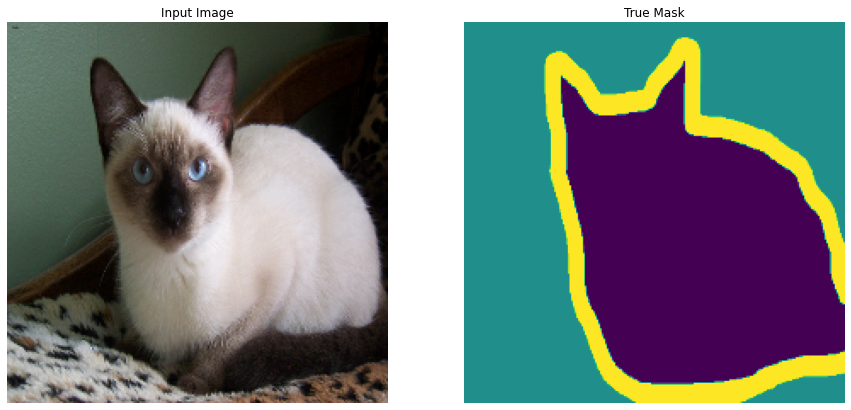

In [40]:

# myModel 재정의
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = myModel.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(myModel.predict(sample_image[tf.newaxis, ...]))])
    
for image, mask in train.take(4):
  sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

In [41]:
myModel.compile('Adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

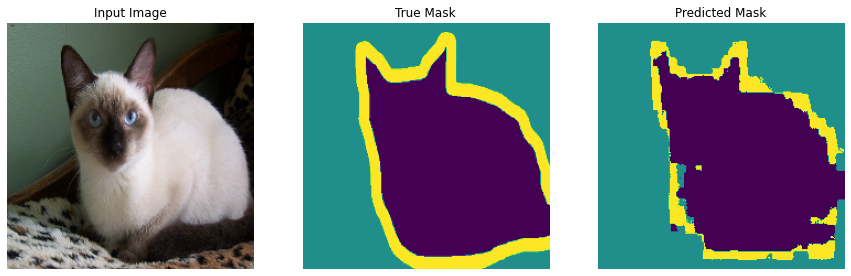


에포크 이후 예측 예시 20

57/57 [==============================] - 81s 1s/step - loss: 0.2515 - val_loss: 0.4251


In [42]:
model_history = myModel.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

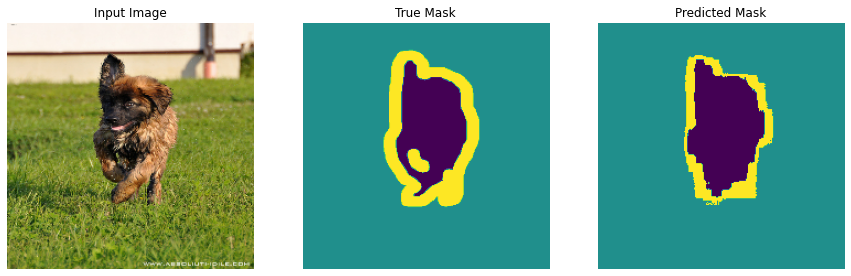

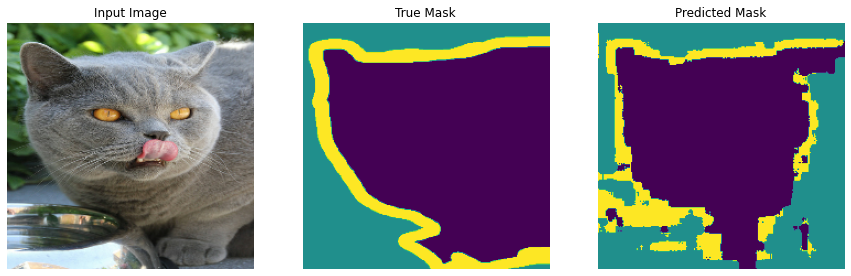

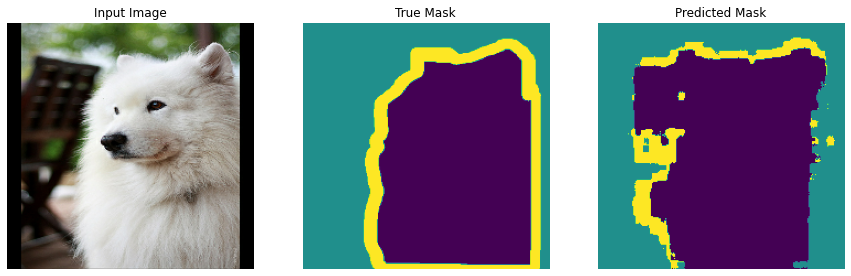

In [43]:
show_predictions(test_dataset,3)